# Predictive distribution sampling


## General imports

In [1]:
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
from LocalBayesPermus.models.PlackettLuce import PlackettLuceDirichlet
from LocalBayesPermus.models.PlackettLuce import PlackettLuceGamma
from LocalBayesPermus.models.BradleyTerry import BradleyTerry
from LocalBayesPermus.models.MallowsModel import MallowsModel
from LocalBayesPermus.figure.plot import Plot

/home/jrojasdelgado/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## Random seed

In [4]:
seed = 1

In [5]:
np.random.seed(seed)

## Preliminaries

In [6]:
placettLuceDirichlet = PlackettLuceDirichlet(alpha=[1], num_samples=1000, seed=seed)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bbca5f288725f8af3b4a4302d7710bf4 NOW.


In [7]:
def get_posterior_samples(orderings, weights, num_samples=1000):
  num_instances, num_algorithms = orderings.shape

  # Priors definition
  dirichlet_alpha_pl = num_algorithms * [1]
    
  # Update model priors and other hyper-parameters
  placettLuceDirichlet.alpha = dirichlet_alpha_pl
  placettLuceDirichlet.num_samples = num_samples
  
  # Obtain the samples
  pld = placettLuceDirichlet.sample_posterior(orderings, weights)

  return pld

In [8]:
def sample(theta):
    pi = []
    n = len(theta)
    pool = [i for i in range(n)]

    while len(pi) < n:
        probs = [theta[i] / np.sum([theta[j] for j in pool]) for i in pool]
        item = np.random.choice(pool, p=probs)
        pi.append(item)
        pool.remove(item)

    return pi

In [9]:
def estimator(samples):
    m, n = samples.shape
    return np.sum(samples, axis=0) / m

In [10]:
def estimator_estimator(samples):
    m, n = samples.shape
    probs = np.zeros(n)
    for theta in samples:
        pi = sample(theta)
        probs[pi[0]] += 1
    return probs / m

In [11]:
def top_probs_from_scores(scores):
    m, n = scores.shape
    probs = np.zeros(n)
    
    for score in scores:
        indices = np.argsort(score)
        probs[indices[0]] += 1
        
        for i in range(1, n):
            if score[indices[i - 1]] == score[indices[i]]:
                probs[indices[i]] += 1
            else:
                break
    
    return probs / np.sum(probs)

## Real Data Analysis

In [12]:
from utils.Real import *

In [19]:
# File names of the data for the different algorithms
algorithms = ['A', 'B', 'AGA', 'VNS', 'NVNS']

# Algorith names
algorithm_names = ['GM-EDA', 'HGM-EDA', 'AGA', 'VNS', 'NVNS']

# Load the data from file
orderingsT, scoresT = load_permus_from_CEB('data/CEB19/T', algorithms)
orderingsR, scoresR = load_permus_from_CEB('data/CEB19/R', algorithms)

# Concatenate Taillard instances with the Random instances
scores = np.concatenate((scoresT, scoresR), axis=0)
orderings = np.concatenate((orderingsT, orderingsR), axis=0)

sam_orderings, sam_scores = get_sample(orderings, scores, 100)
counts = get_counts(sam_scores)
sam_orderings, sam_weights = unroll(sam_orderings, counts)

In [22]:
top_probs = top_probs_from_scores(scores)

In [20]:
trials = np.arange(0, 100, 1)
sample_sizes = np.arange(200, 1000, 100)
estimators = ["Estimator A", "Estimator B"]

In [21]:
index = pd.MultiIndex.from_tuples(itertools.product(trials, sample_sizes, estimators), names=['Trial', 'Number of posterior samples', 'Estimator'])
df = pd.DataFrame(index=index, columns=algorithm_names)

In [23]:
for trial in trials:
    print("\r", "Trial ", trial + 1, " out of ", np.max(trials) + 1, end="")
    for size in sample_sizes:
        samples = get_posterior_samples(sam_orderings, sam_weights, size)
        
        estimation = estimator(samples)
        for prob, algorithm in zip(estimation, algorithm_names):
            df.loc[(trial, size, 'Estimator A'), algorithm] = prob
            
        estimation = estimator_estimator(samples)
        for prob, algorithm in zip(estimation, algorithm_names):
            df.loc[(trial, size, 'Estimator B'), algorithm] = prob

 Trial  100  out of  100

<Figure size 432x288 with 0 Axes>

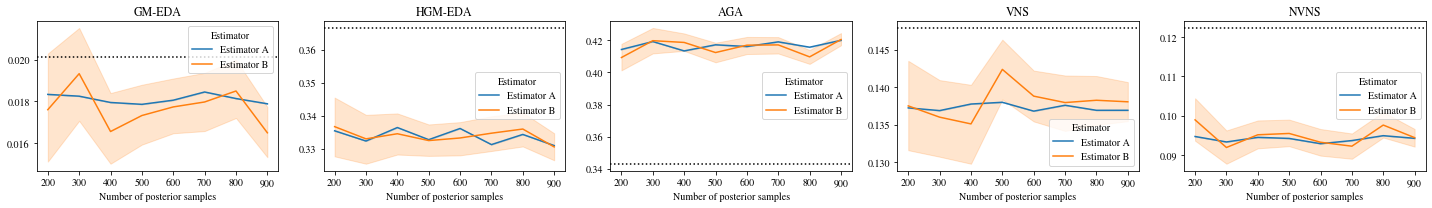

In [35]:
fig = plt.figure()
fig, axs = plt.subplots(1, 5, figsize=(20, 3))

for i, ax in enumerate(axs):
    sns.lineplot(data=df, x="Number of posterior samples", y=algorithm_names[i], hue="Estimator", ax=ax)
    ax.axhline(y=top_probs[i], linestyle=':', color='black', label='Ground truth')
    ax.set_title(algorithm_names[i])
    ax.set_ylabel("")
plt.tight_layout()

In [36]:
fig.savefig("img/RR.Predictive.Estimations.pdf", bbox_inches='tight')